### Q Learning Update equation (remains same)

Q Learning control is carried by sampling step by step and updating Q values at each step. We use ε-greedy policy to explore and generate samples. However, the policy learnt is a deterministic greedy policy with no exploration. The Update equation is given below:

$$ 
\DeclareMathOperator*{\max}{max} Q(S,A) \leftarrow Q(S,A) + \alpha * [ R + \gamma * \max_{A'} Q(S’,A’) – Q(S,A)] $$


In experience replay, we store the samples `(s, a, r, s', done)` in a buffer. The samples are generated using an exploratory behavior policy while we improve a deterministic target policy using Q-values. Therefore, we can always use older samples from behavior policy and apply them again and again. We can keep the buffer size fixed to some pre-determined size and keep deleting the older samples as we collect new ones. The process makes learning efficient by reusing a sample multiple times. Rest of the approach remains same. 

In [3]:
# Initial imports and enviroment setup
import sys
import gym
import gym.envs.toy_text
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Q Learning Learning agent class
from collections import defaultdict


class QLearningAgent:
    def __init__(self, alpha, epsilon, gamma, get_possible_actions):
        self.get_possible_actions = get_possible_actions
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self._Q = defaultdict(lambda: defaultdict(lambda: 0))

    def get_Q(self, state, action):
        return self._Q[state][action]

    def set_Q(self, state, action, value):
        self._Q[state][action] = value

    # Q learning update step
    def update(self, state, action, reward, next_state, done):
        if not done:
            best_next_action = self.max_action(next_state)
            td_error = reward + self.gamma * \
                self.get_Q(next_state, best_next_action) - \
                self.get_Q(state, action)
        else:
            td_error = reward - self.get_Q(state, action)

        new_value = self.get_Q(state, action) + self.alpha * td_error
        self.set_Q(state, action, new_value)

    # get best A for Q(S,A) which maximizes the Q(S,a) for actions in state S
    def max_action(self, state):
        actions = self.get_possible_actions(state)
        best_action = []
        best_q_value = float("-inf")

        for action in actions:
            q_s_a = self.get_Q(state, action)
            if q_s_a > best_q_value:
                best_action = [action]
                best_q_value = q_s_a
            elif q_s_a == best_q_value:
                best_action.append(action)
        return np.random.choice(np.array(best_action))

    # choose action as per epsilon-greedy policy for exploration
    def get_action(self, state):
        actions = self.get_possible_actions(state)

        if len(actions) == 0:
            return None

        if np.random.random() < self.epsilon:
            a = np.random.choice(actions)
            return a
        else:
            a = self.max_action(state)
            return a

In [5]:
# plot rewards
def plot_rewards(env_name, rewards, label):
    plt.title("env={}, Mean reward = {:.1f}".format(env_name,
                                                    np.mean(rewards[-20:])))
    plt.plot(rewards, label=label)
    plt.grid()
    plt.legend()
    plt.ylim(-300, 0)
    plt.show()

In [6]:
# print policy Cliff world
def print_policy(env, agent):
    nR, nC = env._cliff.shape

    actions = '^>v<'

    for y in range(nR):
        for x in range(nC):
            if env._cliff[y, x]:
                print(" C ", end='')
            elif (y * nC + x) == env.start_state_index:
                print(" X ", end='')
            elif (y * nC + x) == nR * nC - 1:
                print(" T ", end='')
            else:
                print(" %s " %
                      actions[agent.max_action(y * nC + x)], end='')
        print()

### Replay Buffer

In [7]:
class ReplayBuffer:
    def __init__(self, size):
        self.size = size  # max number of items in buffer
        self.buffer = []   # array to hold buffer

    def __len__(self):
        return len(self.buffer)

    def add(self, state, action, reward, next_state, done):
        item = (state, action, reward, next_state, done)
        self.buffer = self.buffer[-self.size:] + [item]

    def sample(self, batch_size):
        idxs = np.random.choice(len(self.buffer), batch_size)
        samples = [self.buffer[i] for i in idxs]
        states, actions, rewards, next_states, done_flags = list(zip(*samples))
        return states, actions, rewards, next_states, done_flags

In [14]:
# training algorithm with reply buffer
def train_agent(env, agent, episode_cnt=10000, tmax=10000,
                anneal_eps=True, replay_buffer=None, batch_size=16):
    episode_rewards = []
    for i in range(episode_cnt):
        G = 0
        state = env.reset()
        for t in range(tmax):
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            if replay_buffer:
                replay_buffer.add(state, action, reward, next_state, done)
                states, actions, rewards, next_states, done_flags = \
                        replay_buffer(batch_size)
                for i in range(batch_size):
                    agent.update(states[i], actions[i], rewards[i],
                                 next_states[i], done_flags[i])
            else:
                agent.update(state, action, reward, next_state, done)

            G += reward
            if done:
                episode_rewards.append(G)
                # to reduce the exploration probability epsilon over the
                # training period.
                if anneal_eps:
                    agent.epsilon = agent.epsilon * 0.99
                break
            state = next_state
    return np.array(episode_rewards)

In [15]:
# create cliff world environment
env = gym.envs.toy_text.CliffWalkingEnv()
print(env.__doc__)


    This is a simple implementation of the Gridworld Cliff
    reinforcement learning task.

    Adapted from Example 6.6 (page 106) from Reinforcement Learning: An Introduction
    by Sutton and Barto:
    http://incompleteideas.net/book/bookdraft2018jan1.pdf

    With inspiration from:
    https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py

    The board is a 4x12 matrix, with (using NumPy matrix indexing):
        [3, 0] as the start at bottom-left
        [3, 11] as the goal at bottom-right
        [3, 1..10] as the cliff at bottom-center

    Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward
    and a reset to the start. An episode terminates when the agent reaches the goal.
    


In [16]:
# create a Q Learning agent
agent = QLearningAgent(alpha=0.25, epsilon=0.2, gamma=0.99, 
                       get_possible_actions=lambda s : range(env.nA))

# train agent using replay buffer and get rewards for episodes
rewards = train_agent(env, agent, episode_cnt=5000, 
                      replay_buffer=ReplayBuffer(512))

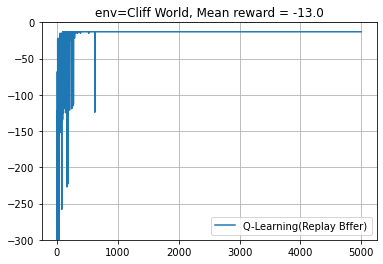

In [17]:
# plot per episode reward
plot_rewards("Cliff World", rewards, 'Q-Learning(Replay Bffer)')

In [18]:
# print policy learnt by the agent
print_policy(env, agent)

 ^  >  >  >  >  >  >  ^  >  >  v  v 
 <  >  v  >  >  >  >  >  v  v  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 
